In [ ]:
!pip install thop

In [ ]:
#library
import torch
import torch.nn as nn
import torch.cuda

import matplotlib.pyplot as plt
import numpy as np

import os
import json
import datetime
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import argparse
import torch.optim as optim
import sys
import itertools
import easydict                 #EasyDict allows to access dict values as attributes (works recursively). A Javascript-like properties dot notation for python dicts.

from thop import profile        
from thop import clever_format  

#Dataset Mean/Standrtvariation
CIFAR10_TRAIN_MEAN = (0.4913997551666284, 0.48215855929893703, 0.4465309133731618)
CIFAR10_TRAIN_STD = (0.24703225141799082, 0.24348516474564, 0.26158783926049628)

ImageNet_TRAIN_MEAN = (0.485, 0.456, 0.406)
ImageNet_TRAIN_STD = (0.229, 0.224, 0.225)


In [ ]:
# 해당 부분은 Tools에 해당하는 내용으로 선택한 Model과 Data Input Size에 따라 Flops와 Param을 구해주는 부분입니다.

def get_flops_params(net, net_name):
    if net_name == 'vgg16':
        x = torch.randn(1, 3, 32, 32)
    elif net_name == "resnet34":
        x = torch.randn(1, 3, 224, 224)
    else:
        print("The net is not provided.")
        exit(0)

    macs, params = profile(model=net, inputs=(x,))         #Model의 Input size, Model Network를 입력
    flops, params = clever_format([macs, params], "%.3f")  #입력된 Model의 정보를 토대로 Flops, Param의 수를 특정 형태로 변환해서 return
    print("flops and params: ", flops, params)
    return flops, params
    # summary(net.cuda(), (3, 32, 32))

# Ex) VGG16
#flops and params:  314.294M 14.992M → 207.102M 5.4M 


In [ ]:
#Argsment Parsing 부분으로 Colab에서 argparse.ArgumentParser() Error가 발생하여 비슷하게 사용할 수 있는 EasyDict라는 라이브러리를 사용
args = easydict.EasyDict({
    
        "net" : "vgg16",
        "dataset": "cifar10",
        "b" : 256,
        "lr": 0.1,
        "e": 90,
        "optim": "SGD",
        "gpu" : 0.1,
        "retrainflag" : "store_true",
        "retrainepoch" : 20,
        "retrainlr" : 0.001,
        "trainflag" : "store_true",
        "pruneflag" : "store_true",
        "sortflag" : "store_true",
        "independentflag" : "store_true",
        "shortcutflag" : "store_true",
        "prune_channels" : "+",
        "prune_layers" : "+"
 
})

# # Get Argument
# def get_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("-net", default='resnet34', help='net type')
#     parser.add_argument("-dataset", default='imagenet', help='dataset')
#     parser.add_argument("-b", default=256, type=int, help='batch size')
#     parser.add_argument("-lr", default=0.1, help='initial learning rate', type=float)
#     parser.add_argument("-e", default=90, help='EPOCH', type=int)
#     parser.add_argument("-optim", default="SGD", help='optimizer')
#     parser.add_argument("-gpu", default="0,1", help='select GPU', type=str)
#     parser.add_argument("-retrainflag", action='store_true', help='retrain or not', default=False)
#     parser.add_argument("-retrainepoch", default=20, help='retrain EPOCH', type=int)
#     parser.add_argument("-retrainlr", default=0.001, help='retrain learning rate', type=float)
#     parser.add_argument("-trainflag", action='store_true', help='train or not', default=False)
#     parser.add_argument("-pruneflag", action='store_true', help='prune or not', default=False)
#     parser.add_argument("-sortflag", action='store_true', help='sort filter by abs sum of weights or not', default=False)
#     parser.add_argument("-independentflag", action='store_true', help='pruning strategy', default=False)
#     parser.add_argument("-shortcutflag", action='store_true', help='prune the shortcut', default=True)
#     parser.add_argument("-prune_channels",  nargs='+', type=int, help='the number of channels to prune corresponding to the prune_layers')
#     parser.add_argument("-prune_layers",  nargs='+', help='the layers to prune')
#     args = parser.parse_args()
#     return args
print(args)

{'net': 'vgg16', 'dataset': 'cifar10', 'b': 256, 'lr': 0.1, 'e': 90, 'optim': 'SGD', 'gpu': 0.1, 'retrainflag': 'store_true', 'retrainepoch': 20, 'retrainlr': 0.001, 'trainflag': 'store_true', 'pruneflag': 'store_true', 'sortflag': 'store_true', 'independentflag': 'store_true', 'shortcutflag': 'store_true', 'prune_channels': '+', 'prune_layers': '+'}


In [ ]:
# 해당 부분은 Optimizer와 Scheduler를 구성하는 부분입니다.

CIFAR10_MILESTONES = [60, 120, 160]
ImageNet_MILESTONES = [30, 60]


def get_optim_sche(lr, opt, net, dataset, retrain=False):
    if opt == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    if retrain:
        scheduler = None

    else:
        MILESTONES = []
        gamma = 0
        if dataset == 'cifar10':
            MILESTONES = CIFAR10_MILESTONES
            gamma = 0.2

        elif dataset == 'imagenet':
            MILESTONES = ImageNet_MILESTONES
            gamma = 0.1

        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=gamma, last_epoch=-1)
        
    return optimizer, scheduler

In [ ]:
# 해당 부분은 Model의 기본 구조를 정의하고 선택한 Dataset을 불러오는 Loader 부분입니다.

def MyResNet34():
    return torchvision.models.resnet34(pretrained=True)

class VGG16(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        net = torchvision.models.vgg16_bn(pretrained=False)
        self.features = net.features
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_class)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(x.size(0), -1)
        out = self.classifier(out)
        return out


def MyVgg16(num_class=10):
    return VGG16(num_class)


# Data Loader
def get_train_loader(args):
    if args.dataset == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=CIFAR10_TRAIN_MEAN, std=CIFAR10_TRAIN_STD)
        ])

        traindata = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        trainloader = DataLoader(traindata, batch_size=args.b, shuffle=True, num_workers=2)
        return trainloader
        
    elif args.dataset == 'imagenet':
        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=ImageNet_TRAIN_MEAN, std=ImageNet_TRAIN_STD)
        ])

        traindata = torchvision.datasets.ImageFolder(root='./data/imagenet/train',
                                                     transform=transform_train)
        trainloader = DataLoader(traindata, batch_size=args.b, shuffle=True, num_workers=2)
        return trainloader


def get_test_loader(args):
    if args.dataset == 'cifar10':
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=CIFAR10_TRAIN_MEAN, std=CIFAR10_TRAIN_STD)
        ])

        testdata = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
        testloader = DataLoader(testdata, batch_size=args.b, shuffle=True, num_workers=2)
        return testloader
    elif args.dataset == 'imagenet':
        transform_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=ImageNet_TRAIN_MEAN, std=ImageNet_TRAIN_STD)
        ])

        testdata = torchvision.datasets.ImageFolder(root='./data/imagenet/val', transform=transform_test)
        testloader = DataLoader(testdata, batch_size=args.b, shuffle=True, num_workers=2)
        return 

In [ ]:
#Pruning을 진행하는 핵심 부분


#Network 종류에 따라 Pruning 방법을 구분 → Residual Block 유무에 의해 나눈다.
def prune_net(net, independentflag, prune_layers, prune_channels, net_name, shortcutflag):
    print("pruning:")
    if net_name == 'vgg16':
        return prune_vgg(net, independentflag, prune_layers, prune_channels)

    elif net_name == "resnet34":
        return prune_resnet(net, independentflag, prune_layers, prune_channels, shortcutflag)

    else:
        print("The net is not provided.")
        exit(0)



#VGG 기반 Network인 경우의 Pruning 방법
def prune_vgg(net, independentflag, prune_layers, prune_channels):

    last_prune_flag = 0
    arg_index = 0
    conv_index = 1
    residue = None
    #print(net)
    for i in range(len(net.features)):
        if isinstance(net.features[i], nn.Conv2d):
            # prune next layer's filter in dim=1
            if last_prune_flag:
                net.features[i], residue = get_new_conv(net.features[i], remove_channels, 1)
                last_prune_flag = 0

            # prune this layer's filter in dim=0
            if "conv_%d" % conv_index in prune_layers:
                remove_channels = channels_index(net.features[i].weight.data, prune_channels[arg_index], residue, independentflag)
                print(prune_layers[arg_index], remove_channels)
                net.features[i] = get_new_conv(net.features[i], remove_channels, 0)
                last_prune_flag = 1
                arg_index += 1
                
            else:
                residue = None

            conv_index += 1
        elif isinstance(net.features[i], nn.BatchNorm2d) and last_prune_flag:
            # prune bn
            net.features[i] = get_new_norm(net.features[i], remove_channels)

    # prune linear
    if "conv_13" in prune_layers:
        net.classifier[0] = get_new_linear(net.classifier[0], remove_channels)
        
    net = net.cuda()
    print(net)
    return net

#ResNet 기반 Network인 경우의 Pruning 방법
def prune_resnet(net, independentflag, prune_layers, prune_channels, shortcutflag):
    # init
    last_prune_flag = 0
    arg_index = 0
    residue = None
    layers = [net.layer1, net.layer2, net.layer3, net.layer4]

    # prune shortcut
    if shortcutflag:
        downsample_index = 1
        for layer_index in range(len(layers)):
            for block_index in range(len(layers[layer_index])):
                if last_prune_flag:
                    # prune next block's filter in dim=1
                    layers[layer_index][block_index].conv1, residue = get_new_conv(layers[layer_index][block_index].conv1, remove_channels, 1)

                if layer_index >= 1 and block_index == 0:
                    if last_prune_flag:
                        # prune next downsample's filter in dim=1
                        layers[layer_index][block_index].downsample[0], residue = get_new_conv(layers[layer_index][block_index].downsample[0], remove_channels, 1)
                    else:
                        residue = None

                    if "downsample_%d" % downsample_index in prune_layers:]
                        # identify channels to remove
                        remove_channels = channels_index(layers[layer_index][block_index].downsample[0].weight.data, prune_channels[arg_index], residue, independentflag)
                        print(prune_layers[arg_index], remove_channels)
                        # prune downsample's filter in dim=0
                        layers[layer_index][block_index].downsample[0] = get_new_conv(layers[layer_index][block_index].downsample[0], remove_channels, 0)
                        # prune downsample's bn
                        layers[layer_index][block_index].downsample[1] = get_new_norm(layers[layer_index][block_index].downsample[1], remove_channels)
                        arg_index += 1
                        last_prune_flag = 1
                    else:
                        last_prune_flag = 0
                    downsample_index += 1

                if last_prune_flag:
                    # prune next block's filter in dim=0
                    layers[layer_index][block_index].conv2 = get_new_conv(layers[layer_index][block_index].conv2, remove_channels, 0)
                    # prune next block's bn
                    layers[layer_index][block_index].bn2 = get_new_norm(layers[layer_index][block_index].bn2, remove_channels)
    # prune linear
    if "downsample_3" in prune_layers:
        net.fc = get_new_linear(net.fc, remove_channels)

    # prune non-shortcut
    else:
        conv_index = 2
        for layer_index in range(len(layers)):
            for block_index in range(len(layers[layer_index])):
                if "conv_%d" % conv_index in prune_layers:
                    # identify channels to remove
                    remove_channels = channels_index(layers[layer_index][block_index].conv1.weight.data, prune_channels[arg_index], residue, independentflag)
                    print(prune_layers[arg_index], remove_channels)
                    # prune this layer's filter in dim=0
                    layers[layer_index][block_index].conv1 = get_new_conv(layers[layer_index][block_index].conv1, remove_channels, 0)
                    # prune next layer's filter in dim=1
                    layers[layer_index][block_index].conv2, residue = get_new_conv(layers[layer_index][block_index].conv2, remove_channels, 1)
                    residue = 0
                    # prune bn
                    layers[layer_index][block_index].bn1 = get_new_norm(layers[layer_index][block_index].bn1,remove_channels)
                    arg_index += 1
                conv_index += 2
    net = net.cuda()
    print(net)
    return net


#L1-Norm을 계산하여 오름차순으로 정렬하여 입력된 Pruning 수치만큼 리스트 리턴
def channels_index(weight_matrix, prune_num, residue, independentflag):
    abs_sum = torch.sum(torch.abs(weight_matrix.view(weight_matrix.size(0), -1)), dim=1)
    if independentflag and residue is not None:
        abs_sum = abs_sum + torch.sum(torch.abs(residue.view(residue.size(0), -1)), dim=1)
    _, indices = torch.sort(abs_sum)
    return indices[:prune_num].tolist()

#ResNet 기반 Network인 경우의 Pruning 방법
def select_channels(weight_matrix, remove_channels, dim):
    indices = torch.tensor(list(set(range(weight_matrix.shape[dim])) - set(remove_channels)))
    new = torch.index_select(weight_matrix, dim, indices.cuda())

    if dim == 1:
      
        residue = torch.index_select(weight_matrix, dim, torch.tensor(remove_channels).cuda())
        return new, residue

    return new

# >>> x = torch.randn(3, 4)
# >>> x
# tensor([[ 0.1427,  0.0231, -0.5414, -1.0009],
#         [-0.4664,  0.2647, -0.1228, -1.1068],
#         [-1.1734, -0.6571,  0.7230, -0.6004]])

# >>> indices = torch.tensor([0, 2])

# >>> torch.index_select(x, 0, indices)
# tensor([[ 0.1427,  0.0231, -0.5414, -1.0009],
#         [-1.1734, -0.6571,  0.7230, -0.6004]])

# >>> torch.index_select(x, 1, indices)
# tensor([[ 0.1427, -0.5414],
#         [-0.4664, -0.1228],
#         [-1.1734,  0.7230]])



#Pruning이후 Conv층을 새로 구성해주는 함수
def get_new_conv(old_conv, remove_channels, dim):
    
    if dim == 0:
        new_conv = nn.Conv2d(in_channels=old_conv.in_channels,
                             out_channels=old_conv.out_channels - len(remove_channels),
                             kernel_size=old_conv.kernel_size, stride=old_conv.stride, padding=old_conv.padding,
                             dilation=old_conv.dilation, bias=old_conv.bias is not None)
        
        new_conv.weight.data = select_channels(old_conv.weight.data, remove_channels, dim)

        if old_conv.bias is not None:
            new_conv.bias.data = select_channels(old_conv.bias.data, remove_channels, dim)

        return new_conv

    else:
        new_conv = nn.Conv2d(in_channels=old_conv.in_channels - len(remove_channels), 
                             out_channels=old_conv.out_channels,
                             kernel_size=old_conv.kernel_size, stride=old_conv.stride, padding=old_conv.padding,
                             dilation=old_conv.dilation, bias=old_conv.bias is not None)
        new_conv.weight.data, residue = select_channels(old_conv.weight.data, remove_channels, dim)
        
        if old_conv.bias is not None:
            new_conv.bias.data = old_conv.bias.data
        return new_conv, residue


#Pruning이후 BatchNorm을 새로 구성해주는 함수
def get_new_norm(old_norm, remove_channels):
    new = torch.nn.BatchNorm2d(num_features=old_norm.num_features - len(remove_channels), eps=old_norm.eps,
                               momentum=old_norm.momentum, affine=old_norm.affine,
                               track_running_stats=old_norm.track_running_stats)
    new.weight.data = select_channels(old_norm.weight.data, remove_channels, 0)
    new.bias.data = select_channels(old_norm.bias.data, remove_channels, 0)

    if old_norm.track_running_stats:
        new.running_mean.data = select_channels(old_norm.running_mean.data, remove_channels, 0)
        new.running_var.data = select_channels(old_norm.running_var.data, remove_channels, 0)

    return new

#Pruning이후 Classifier Linear 층을 새로 구성해주는 함수
def get_new_linear(old_linear, remove_channels):
    new = torch.nn.Linear(in_features=old_linear.in_features - len(remove_channels),
                          out_features=old_linear.out_features, bias=old_linear.bias is not None)
    new.weight.data, residue = select_channels(old_linear.weight.data, remove_channels, 1)
    if old_linear.bias is not None:
        new.bias.data = old_linear.bias.data
    return new

In [ ]:
# 전체 Code에서 Train을 담당하는 부분의 코드이며 아래순서로 동작한다.
#Step1 : DataLoad
#Step2 : Model Select & 
#Step3 : Train
#Step4 : Pruning
#Step5 : Retrain

CHECK_POINT_PATH = "./checkpoint"

# train_epoch
# Epoch에 따라 위에서 지정한 Data로 Train을 진행하는 함수
def train_epoch(net, epoch, trainloader, loss_function, optimizer, fepoch, fstep):
    net.train()

    length = len(trainloader)
    total_sample = len(trainloader.dataset)
    total_loss = 0
    correct_1 = 0
    correct_5 = 0
    batch_size = 0

    for step, (x, y) in enumerate(trainloader):
        x = x.cuda()
        y = y.cuda()
        if step == 0:
            batch_size = len(y)
        optimizer.zero_grad()

        output = net(x)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predict = output.topk(5, 1, True, True)
        # _, predict = torch.max(output, 1)
        predict = predict.t()
        correct = predict.eq(y.view(1, -1).expand_as(predict))
        correct_1 += correct[:1].view(-1).sum()
        correct_5 += correct[:5].reshape(-1).sum()
        
        # correct += (predict == y).sum()

        if step % 20 == 0:
            print("Epoch:{}\t Step:{}\t TrainedSample:{}\t TotalSample:{}\t Loss:{:.3f}".format(
                epoch + 1, step + 1, step * batch_size + len(y), total_sample, loss.item()
            ))
        if step % 40 == 0:
            fstep.write("Epoch:{}\t Step:{}\t TrainedSample:{}\t TotalSample:{}\t Loss:{:.3f}\n".format(
                epoch + 1, step + 1, step * batch_size + len(y), total_sample, loss.item()
            ))
            fstep.flush()

    fepoch.write("Epoch:{}\t Loss:{:.3f}\t lr:{:.5f}\t acc1:{:.3%}\t acc5:{:.3%}\n".format(
        epoch + 1, total_loss/length, optimizer.param_groups[0]['lr'], float(correct_1) / total_sample,
        float(correct_5)/total_sample
    ))
    fepoch.flush()
    return net

# Epoch에 따라 위에서 지정한 Data로 Test를 진행하는 함수
def eval_epoch(net, testloader):
    loss_function = nn.CrossEntropyLoss()
    net.eval()

    length = len(testloader)
    total_sample = len(testloader.dataset)
    total_loss = 0
    correct_1 = 0
    correct_5 = 0
    inference_time = 0

    for step, (x, y) in enumerate(testloader):
        x = x.cuda()
        y = y.cuda()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        output = net(x)
        # _, predict = torch.max(output, 1)
        _, predict = output.topk(5, 1, True, True)
        end.record()

        # Waits for everything to finish running
        torch.cuda.synchronize()
        inference_time += start.elapsed_time(end)  # milliseconds

        loss = loss_function(output, y)

        total_loss += loss.item()

        predict = predict.t()
        correct = predict.eq(y.view(1, -1).expand_as(predict))
        correct_1 += correct[:1].view(-1).sum()
        correct_5 += correct[:5].reshape(-1).sum()
        # correct += (predict == y).sum()

    acc1 = float(correct_1) / total_sample
    acc5 = float(correct_5) / total_sample
    return acc1, acc5, total_loss/length, inference_time

# 전체 Training을 진행시키는 함수로 Train, Test를 실행
def training(net,total_epoch,dataset,trainloader,testloader,retrain,lr,optim,most_recent_path,train_checkpoint_path):
    # define optimizer, scheduler and loss function
    print(lr, type(lr))
    optimizer, scheduler = get_optim_sche(lr, optim, net, dataset, retrain=retrain)
    loss_function = nn.CrossEntropyLoss()

    # initial best_acc(for early stop) and total_time(for inference time)
    best_acc = 0
    # best_acc = 0.72374
    total_time = 0
    pre_epoch = 0

    if not os.path.exists(train_checkpoint_path):
        os.makedirs(train_checkpoint_path)

    with open(os.path.join(train_checkpoint_path, 'EpochLog.txt'), 'w') as fepoch:
        with open(os.path.join(train_checkpoint_path, 'StepLog.txt'), 'w') as fstep:
            with open(os.path.join(train_checkpoint_path, 'EvalLog.txt'), 'w') as feval:
                with open(os.path.join(train_checkpoint_path, 'Best.txt'), 'w') as fbest:

                    print("start training")
                    for epoch in range(pre_epoch, total_epoch):
                        train_epoch(net, epoch, trainloader, loss_function, optimizer, fepoch, fstep)

                        print("evaluating")
                        accuracy1, accuracy5, averageloss, inference_time = eval_epoch(net, testloader)
                        feval.write("Epoch:{}\t Loss:{:.3f}\t lr:{:.5f}\t acc1:{:.3%}\t acc5:{:.3%}\n".format(
                            epoch + 1, averageloss, optimizer.param_groups[0]['lr'], accuracy1, accuracy5
                        ))
                        feval.flush()

                        if scheduler is not None:
                            scheduler.step()

                        print("saving regular")
                        torch.save(net.state_dict(), os.path.join(train_checkpoint_path, 'regularParam.pth'))

                        if accuracy1 > best_acc:
                            print("saving best")
                            torch.save(net.state_dict(), os.path.join(train_checkpoint_path, 'bestParam.pth'))
                            torch.save(net.state_dict(), os.path.join(most_recent_path, 'bestParam.pth'))
                            fbest.write("Epoch:{}\t Loss:{:.3f}\t lr:{:.5f}\t acc1:{:.3%}\t acc5:{:.3%}\n".format(
                                epoch + 1, averageloss, optimizer.param_groups[0]['lr'], accuracy1, accuracy5
                            ))
                            fbest.flush()
                            best_acc = accuracy1
                        # print(inference_time)
                        total_time += (inference_time / len(testloader.dataset))

                    print(total_time)
                    print(total_time / total_epoch)
    return net


if __name__ == '__main__':
    # arguments from command line
    args = args

    # data processing
    train_loader = get_train_loader(args)
    test_loader = get_test_loader(args)


    # define gpus and get net
    # device_ids = [int(i) for i in list(args.gpu.split(','))]
    net = None
    if args.net == 'vgg16':
        net = MyVgg16(10)
        print(net)

    elif args.net == 'resnet34':
        net = MyResNet34()
        print(net)
    else:
        print('We don\'t support this net.')
        sys.exit()

    # net = nn.DataParallel(net, device_ids=device_ids)
    net = net.cuda()

    # define checkpoint path
    time = str(datetime.date.today() + datetime.timedelta(days=2))
    checkpoint_path = os.path.join(CHECK_POINT_PATH, args.net)
    # print(checkpoint_path)
    train_checkpoint_path = os.path.join(checkpoint_path, 'train', time)
    # print(train_checkpoint_path)
    train_most_recent_path = os.path.join(checkpoint_path, 'train')
    # print(train_most_recent_path)
    prune_checkpoint_path = os.path.join(checkpoint_path, 'prune', time)
    prune_most_recent_path = os.path.join(checkpoint_path, 'prune')
    retrain_checkpoint_path = os.path.join(checkpoint_path, 'retrain', time)
    retrain_most_recent_path = os.path.join(checkpoint_path, 'retrain')

#Training
    if args.trainflag:
        training(net, args.e, args.dataset, train_loader, test_loader, False, args.lr, args.optim,
                 train_most_recent_path, train_checkpoint_path)

#Pruning
    new_net = None
    if args.pruneflag:
        if not os.path.exists(prune_checkpoint_path):
            os.makedirs(prune_checkpoint_path)
        if os.path.exists(os.path.join(train_most_recent_path, 'bestParam.pth')):
            # print(train_most_recent_path)
            net.load_state_dict(torch.load(os.path.join(train_most_recent_path, 'bestParam.pth')))
            print(net.features)
#net : best Traing net
#independentflag : store_true
#prune_layers : "+"
#prune_channel : "+"
#net : vgg16
#shortcutflag : store_true
        new_net = prune_net(net, args.independentflag, args.prune_layers, args.prune_channels, args.net, args.shortcutflag)

        f, p = get_flops_params(new_net.cpu(), args.net)
        new_net = new_net.cuda()

        with open(os.path.join(prune_checkpoint_path, 'flops_and_params'), 'w') as fp:
            fp.write("flops:{}\t params:{}\n".format(f, p))
            fp.flush()

        torch.save(new_net.state_dict(), os.path.join(prune_checkpoint_path, 'prunedParam.pth'))
        torch.save(new_net.state_dict(), os.path.join(prune_most_recent_path, 'prunedParam.pth'))

#Retrain after Pruning
    if args.retrainflag:
        # new_net.load_state_dict(torch.load(os.path.join(retrain_most_recent_path, 'regularParam.pth')))
        # print("evaluating")
        # top1, top5, loss, infer_time = eval_epoch(new_net, test_loader)
        # print("Eval after pruning:\t Loss:{:.3f}\t acc1:{:.3%}\t acc5:{:.3%}\t Inference time:{:.3%}\n"
        #       .format(loss, top1, top5, infer_time / len(test_loader.dataset)))
        training(net, args.retrainepoch, args.dataset, train_loader, test_loader, True, args.retrainlr, args.optim, retrain_most_recent_path, retrain_checkpoint_path)




Files already downloaded and verified
VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

No handles with labels found to put in legend.


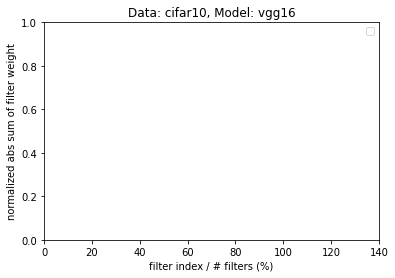

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
    (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (26): ReLU(inplace=True)
    (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (32): ReLU(inplace=True)
    (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (36): ReLU(inplace=True)
    (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
# 전체 Code에서 Train한 Model의 Pruning 결과를 분석하는 부분의 코드이며 아래순서로 동작한다.
#Step1 : 각 Network별 L1 Norm을 순서대로 정렬하여 보여줌
#Step2 : Pruning or Pruning+Retrain의 결과를 Pruning 비율에 따라 보여줌

# Prune Analysis
CHECK_POINT_PATH = "./checkpoint"

#Plotting용 Parameter 
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

#Model 종류에 따라 Pretrain된 Model에서 가져와야 할 각 네트워크층 및 채널수를 미리 지정
vgg16_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9', 'conv_10',
                'conv_11', 'conv_12', 'conv_13']
vgg16_total_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
first_layers = ['conv_2', 'conv_4', 'conv_6', 'conv_8', 'conv_10', 'conv_12', 'conv_14', 'conv_16', 'conv_18',
                'conv_20', 'conv_22', 'conv_24', 'conv_26', 'conv_28', 'conv_30', 'conv_32']
first_total_channels = [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
shortcut_layers = ['downsample_1', 'downsample_2', 'downsample_3']
shortcut_total_channels = [128, 256, 512]
# device_ids = [0, 1]

#각 Filter의 가중치의 L1 Norm을 그래프로 보여주기 위한 함수
def sort_filter(args):

#step1 앞에서 훈련시킨 네트워크를 불러옴
    # get the desired net
    load_path = os.path.join(CHECK_POINT_PATH, args.net, "train", "bestParam.pth")
    net = get_net(args.net)
    new_net = get_net(args.net)
    if os.path.exists(load_path):
        net.load_state_dict(torch.load(load_path))

#step2 불러온 네트워크의 conv2d층의 가중치의 L1-Norm을 구하여 Plot을 실행
    # make the figure
    shortcut = ""
    if args.shortcutflag:
        shortcut = "shortcut_"
    plt.figure()
    conv_count = 0
    figure_count = 1
    for layer in net.features:
        if isinstance(layer, nn.Conv2d):
            # exclude shortcut conv or residual conv
            if args.shortcutflag:
                if layer.kernel_size != (1, 1):
                    continue
            else:
                if layer.kernel_size == (1, 1):
                    continue
            line_style = colors[conv_count % len(colors)] + lines[conv_count // len(colors) % len(lines)]
            weight = layer.weight.data.cpu().numpy()
            abs_sum_sorted = np.sort(np.sum(((np.abs(weight)).reshape(weight.shape[0], -1)), axis=1), axis=0)[::-1]
            norm_filter = abs_sum_sorted/abs_sum_sorted[0]
            conv_count += 1
            plt.plot(np.linspace(0, 100, norm_filter.shape[0]), norm_filter, line_style, label=shortcut + 'conv %d' % conv_count)

            # if there are too many convs in a figure, make a new one
            if conv_count % 17 == 0:
                plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net)
                plt.ylabel("normalized abs sum of filter weight")
                plt.xlabel("filter index / # filters (%)")
                plt.legend(loc='upper right')
                plt.xlim([0, 140])
                # plt.grid()
                plt.savefig(args.net + "_" + shortcut + str(figure_count) + "_" + "filters_ranked.png",
                            bbox_inches='tight')
                plt.show()
                plt.figure()
                figure_count += 1

    plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net)
    plt.ylabel("normalized abs sum of filter weight")
    plt.xlabel("filter index / # filters (%)")
    plt.legend(loc='upper right')
    plt.xlim([0, 140])

    # plt.grid()
    plt.savefig(args.net + "_" + shortcut + str(figure_count) + "_" + "filters_ranked.png", bbox_inches='tight')
    plt.show()

#Pruning을 진행한 후 Pruning 비율에 따라 성능을 보여주는 함수
#Step1 : Load Pretrained Model
#Step2 : Pruning
#Step3 : Plot an Accuracy by Pruning rate 

def prune_analysis(args):

#Step1 앞에서 훈련시킨 네트워크를 불러옴
    # get the desired net layers, and channels
    layers, total_channels = get_list(args.net, args.shortcutflag)
    load_path = os.path.join(CHECK_POINT_PATH, args.net, "train", "bestParam.pth")

    # get the args for eval
    test_loader = get_test_loader(args)
    independentflag = False
    if args.shortcutflag:
        shortcut = "shortcut_"
    else:
        shortcut = ""

    # the parameter for prune
    max_prune_ratio = 0.90
    accuracy1 = {}
    accuracy5 = {}

#Step2 불러온 네트워크의 Pruning할 비율을 정하고 Pruning 진행
    # for all layers in the net
    for conv, channels in zip(layers, total_channels):
        new_net = get_net(args.net)
        if os.path.exists(load_path):
            new_net.load_state_dict(torch.load(load_path))

        print("evaluating")
        top1, top5, loss, infer_time = eval_epoch(new_net, test_loader)
        print("Eval before pruning" + ": Loss:{:.3f}\t acc1:{:.3%}\t acc5:{:.3%}\t Inference time:{:.3}\n"
              .format(loss, top1, top5, infer_time / len(test_loader.dataset)))

        accuracy1[conv] = [top1]
        accuracy5[conv] = [top5]

        prune_layers = [conv]
        prune_channels = np.linspace(0, int(channels * max_prune_ratio), 10, dtype=int)
        prune_channels = (prune_channels[1:] - prune_channels[:-1]).tolist()

        # for each layer
        for index, prune_channel in enumerate(prune_channels):
            # prune
            new_net = prune_net(new_net, independentflag, prune_layers, [prune_channel], args.net, args.shortcutflag)

            # eval
            print("evaluating")
            top1, top5, loss, infer_time = eval_epoch(new_net, test_loader)
            print("Eval after pruning " + conv, index, ":\t Loss:{:.3f}\t acc1:{:.3%}\t acc5:{:.3%}\t "
                                                       "Inference time:{:.3}\n".format(loss, top1, top5, infer_time /
                                                                                       len(test_loader.dataset)))
            accuracy1[conv].append(top1)
            accuracy5[conv].append(top5)

            with open('top1', 'w') as fout:
                json.dump(accuracy1, fout)

            with open('top5', 'w') as fout:
                json.dump(accuracy5, fout)
    # with open('top1', "r") as jsonfile:
    #     accuracy1 = json.load(jsonfile)
    # with open('top5', "r") as jsonfile:
    #     accuracy5 = json.load(jsonfile)


#Step3 Retrain까지 진행된 Model의 각 층에 대해서 Pruning 비율 별로 Accuracy를 그려주는 부분

    plt.figure()
    for index, (conv, acc1) in enumerate(accuracy1.items()):
        line_style = colors[index % len(colors)] + lines[index // len(colors) % len(lines)] + 'o'
        xs = np.linspace(0, 90, len(acc1))
        plt.plot(xs, acc1, line_style,
                 label=conv+' '+str(total_channels[index]))
    plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net + ", pruned smallest filters (greedy)")
    plt.ylabel("Accuracy(top1)")
    plt.xlabel("Filters Pruned Away(%)")
    plt.legend(loc='upper right')
    plt.xlim([0, 100])
    # plt.ylim([0.50, 0.75])
    # plt.grid()
    plt.savefig(shortcut+args.dataset + "_pruned_top1.png", bbox_inches='tight')
    plt.show()

    plt.figure()
    for index, (conv, acc5) in enumerate(accuracy5.items()):
        line_style = colors[index % len(colors)] + lines[index // len(colors) % len(lines)] + 'o'
        xs = np.linspace(0, 90, len(acc5))
        plt.plot(xs, acc5, line_style,
                 label=conv + ' ' + str(total_channels[index]))
    plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net + ", pruned smallest filters (greedy)")
    plt.ylabel("Accuracy(top5)")
    plt.xlabel("Filters Pruned Away(%)")
    plt.legend(loc='upper right')
    plt.xlim([0, 100])
    # plt.ylim([0.5, 0.75])
    # plt.grid()
    plt.savefig(shortcut+args.dataset + "_pruned_top5.png", bbox_inches='tight')
    plt.show()

#Pruning을 진행한 후 Retrain 까지 실행하여 Pruning 비율에 따라 성능을 보여주는 함수
#Step1 : Load Pretrained Model
#Step2 : Pruning & Retrain
#Step3 : Plot an Accuracy by Pruning rate 
def prune_retrain_analysis(args):


#Step1 앞에서 훈련시킨 네트워크를 불러옴
    load_path = os.path.join(CHECK_POINT_PATH, args.net, "train", "bestParam.pth")
    test_loader = get_test_loader(args)

    if args.shortcutflag:
        shortcut = "shortcut_"
    else:
        shortcut = ""

    new_net = get_net(args.net)
    if os.path.exists(load_path):
        new_net.load_state_dict(torch.load(load_path))
    top1_org, top5_org, loss, infer_time = eval_epoch(new_net, test_loader)
    layers, total_channels = get_list(args.net, shortcut)


#Step2 불러온 네트워크의 Pruning할 비율을 정하고 Pruning & Retrain 진행
    independentflag = False
    max_prune_ratio = 0.90
    min_prune_ratio = 0.20
    accuracy1 = {}
    accuracy5 = {}

    # for all layers
    for conv, channels in zip(layers, total_channels):
        accuracy1[conv] = [top1_org]
        accuracy5[conv] = [top5_org]

        prune_layers = [conv]
        prune_channels = np.linspace(int(channels * min_prune_ratio), int(channels * max_prune_ratio), 8, dtype=int).tolist()

        # for each layer
        for index, prune_channel in enumerate(prune_channels):
            # get net and prune
            new_net = get_net(args.net)
            if os.path.exists(load_path):
                new_net.load_state_dict(torch.load(load_path))
            new_net = prune_net(new_net, independentflag, prune_layers, [prune_channel], args.net, shortcut)

            # retrain
            new_net = filter_retrain(new_net, conv + ':pruned %d' % prune_channel)

            # eval
            top1, top5, loss, infer_time = eval_epoch(new_net, test_loader)
            print("Eval after pruning" + conv, index, ":\t Loss:{:.3f}\t acc1:{:.3%}\t acc5:{:.3%}\t "
                                                      "Inference time:{:.3}\n".format(loss, top1, top5, infer_time /
                                                                                      len(test_loader.dataset)))
            accuracy1[conv].append(top1)
            accuracy5[conv].append(top5)

            with open('top1', 'w') as fout:
                json.dump(accuracy1, fout)

            with open('top5', 'w') as fout:
                json.dump(accuracy5, fout)

    # with open('top1', "r") as jsonfile:
    #     accuracy1 = json.load(jsonfile)
    # with open('top5', "r") as jsonfile:
    #     accuracy5 = json.load(jsonfile)

#Step3 Retrain까지 진행된 Model의 각 층에 대해서 Pruning 비율 별로 Accuracy를 그려주는 부분
    plt.figure()
    for index, (conv, acc1) in enumerate(accuracy1.items()):
        line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
        xs = [0] + list(np.linspace(20, 90, len(acc1)-1))
        xs = np.array(xs)
        plt.plot(xs, acc1, line_style,
                 label=conv + ' ' + str(total_channels[index]))
    plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net + ", pruned smallest filters (greedy), retrain %d "
                                                                     "epochs" % args.retrainepoch)
    plt.ylabel("Accuracy(top1)")
    plt.xlabel("Filters Pruned Away(%)")
    plt.legend(loc='lower left')
    plt.xlim([0, 100])
    # plt.grid()
    plt.savefig(shortcut + args.dataset + "_retrained_top1.png", bbox_inches='tight')
    plt.show()

    plt.figure()

    for index, (conv, acc5) in enumerate(accuracy5.items()):
        line_style = colors[index % len(colors)] + lines[index // len(colors)] + 'o'
        xs = [0] + list(np.linspace(20, 90, len(acc5)-1))
        xs = np.array(xs)
        plt.plot(xs, acc5, line_style, label=conv + ' ' + str(total_channels[index]))
    
    plt.title("Data: %s" % args.dataset + ", Model: %s" % args.net + ", pruned smallest filters (greedy), retrain %d "
                                                                     "epochs" % args.retrainepoch)
    plt.ylabel("Accuracy(top5)")
    plt.xlabel("Filters Pruned Away(%)")
    plt.legend(loc='lower left')
    plt.xlim([0, 100])
    # plt.grid()
    plt.savefig(shortcut + args.dataset + "_retrained_top5.png", bbox_inches='tight')
    plt.show()

#Model의 종류에 따라 Network 뼈대를 만들어주기 위한 함수
def get_net(net_name):
    if net_name == 'vgg16':
        net = MyVgg16(10)
    elif net_name == "resnet34":
        net = MyResNet34()
    else:
        print("The net is not provided.")
        exit(0)

    # net = nn.DataParallel(net, device_ids=device_ids)
    net = net.cuda()
    return net

#앞서 정의해둔 Model 별로 가져와야할 Network층 및 채널수를 불러오는 함수
def get_list(net_name, shortcutflag):
    if net_name == 'vgg16':
        return vgg16_layers, vgg16_total_channels
    elif net_name == "resnet34":
        if shortcutflag:
            return shortcut_layers, shortcut_total_channels
        else:
            return first_layers, first_total_channels
    else:
        print("The net is not provided.")
        exit(0)

#Retrain을 진행시켜주는 함수로 training call하는 부분밖에 없으며 
#filter_retrain 함수자체가 Pruning을 진행하고 호출되어 함수명을 filter_retrain로 표시
def filter_retrain(net, dirname):
    checkpoint_path = os.path.join(CHECK_POINT_PATH, args.net)
    time = str(datetime.date.today())
    most_recent_path = os.path.join(checkpoint_path, 'retrain', "most_recnet", dirname)
    if not os.path.exists(most_recent_path):
        os.makedirs(most_recent_path)
    retrain_checkpoint_path = os.path.join(checkpoint_path, 'retrain', time, dirname)
    if not os.path.exists(retrain_checkpoint_path):
        os.makedirs(retrain_checkpoint_path)

    train_loader = get_train_loader(args)
    test_loader = get_test_loader(args)

    net = training(net, 20, args.dataset, train_loader, test_loader, True, 0.001, 'SGD', retrain_checkpoint_path, most_recent_path)
    return net


if __name__ == '__main__':
    # arguments from command line
    args = args
    # Analysis
    if args.sortflag:
        sort_filter(args)

    if args.pruneflag:

        if args.retrainflag:
            prune_retrain_analysis(args)

        else:
            prune_analysis(args)


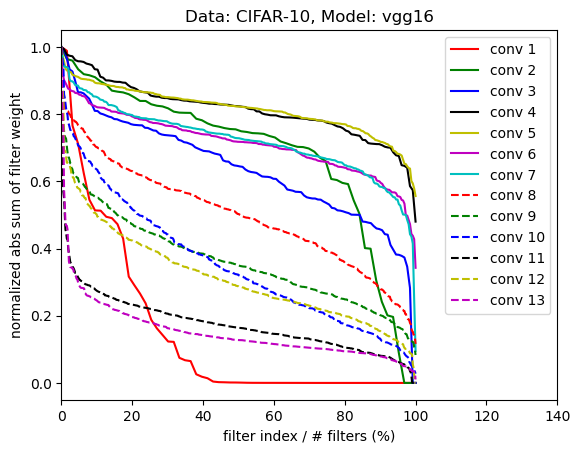


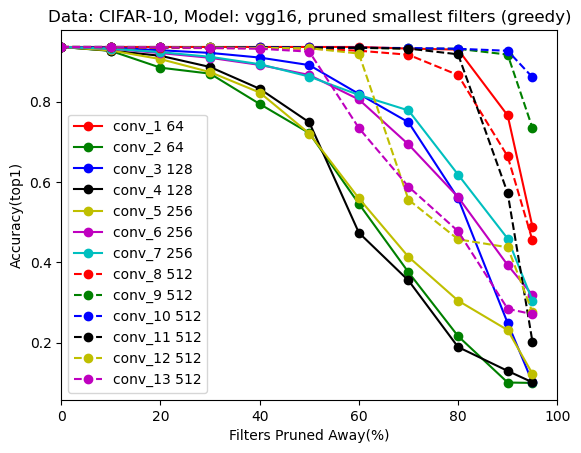

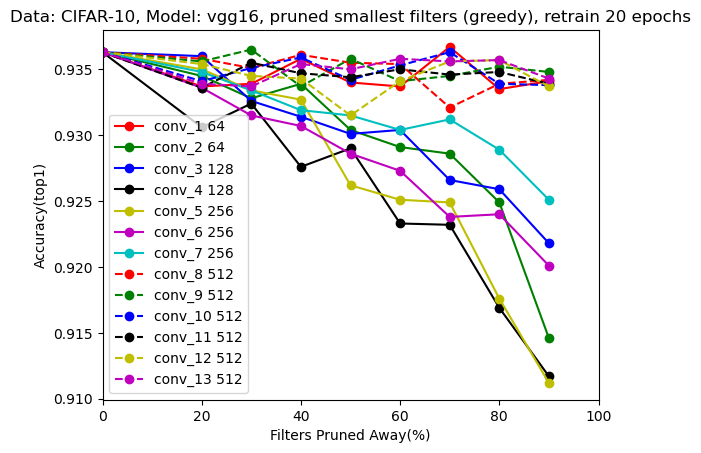